# **Лабораторная работа 1**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

В данном задании вашей задачей будет построить простую модель для задачи **Image Captioning** - по изображению (image) сгенерировать текстовый заголовок (caption)

В ноутбуке будет несколько оцениваемых частей:
1. **Подготовка данных для модели** (*3 балла*) --> требуется заполнить пропуски и составить пайплайн предобработки данных
2. **Построение модели** (*2 балла*) --> требуется заполнить пропуски и составить пайплайн сборки модели
3. **Обучение модели** (*2 балла*) --> требуется заполнить пропуски и составить пайплайн обучения модели
4. **Оценка результатов** (*1 балл*) --> требуется заполнить пропуски и получить предсказания модели

_Начиная с этого этапа идут эксперименты и почти весь код вам нужно будет писать самим_

5. **Валидация качества** (*2 балл*) --> вам нужно будет обучить модель, чтобы превзойти определённые пороги на валидационной выборке
6. **Эксперименты** (*бонусные до 10 баллов*) --> вам нужно будет предоставить класс сбора/предобработки датасета и обученную модель для проверки на отложенной тестовой выборке. За преодоление определённых порогов будут выставляться бонусные баллы.

**Структура данных:** 
- Вместе с заданием вам предложен файл __dataset.tar.gz__, в нём вы найдёте папку data, в которой присутствуют две папки с изображениями (**train** и **val**) в формате .png и два файла **captions_train.tsv** и **captions_val.tsv**
- В файлах captions находятся таблицы с 6 полями, разделёнными через **\t**, содержащими `img_id` (название файла с изображением в соответствующей папке) и `caption #1-#5` (5 текстовых заголовков для изображения __img_id__)
- **ВАЖНО!!! ЗАПРЕЩЕНО использовать val в обучении моделей,** только в тестах, т.к. часть баллов в конце ноутбука будет выдаваться в зависимости от результатов вашей модели на val выборке и если вы будете учиться на val срезе, то баллы за весь ноутбук будут аннулированы 

**Концепция простой модели**
- Будем рассматривать задачу предсказания следующего слова в предложении, имея изображение и предыдущие слова
- Для получения фичей из изображений будем использовать крупную свёрточную предобученную архитектуру
- Для получения фичей из предыдущего текста будем использовать рекуррентную архитектуру
- Сконкатенируем фичи по изображению и по тексту, чтобы получить финальный набор фичей
- Линейный слой к размеру словаря над финальным набором фичей
- NLLLoss для оценки предсказания

**Модели большие, подсчёты не быстрые - закладывайте время на обучение моделей и обязательно(!!!) используйте GPU**

А так же в экспериментах обязательно подумайте можно ли как-то ускорить этот процесс?

## 1. Подготовка данных (***3 балла***)

### 1.1 Посмотрим на данные

In [1]:
!wget https://www.dropbox.com/s/pflaj0whd53xhjn/%D0%BB%D0%B0%D0%B1%D0%B01_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.png?dl=0 -O лаба1_модель.png

--2021-10-22 14:58:30--  https://www.dropbox.com/s/pflaj0whd53xhjn/%D0%BB%D0%B0%D0%B1%D0%B01_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pflaj0whd53xhjn/%D0%BB%D0%B0%D0%B1%D0%B01_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.png [following]
--2021-10-22 14:58:30--  https://www.dropbox.com/s/raw/pflaj0whd53xhjn/%D0%BB%D0%B0%D0%B1%D0%B01_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3836ead0013a269531f64a0dea.dl.dropboxusercontent.com/cd/0/inline/BYg-QuZs2NOM_9ZACHVY00yTgY9QJM0sq8sVFicHHozCHuuVSsImtq1YfiBMLyRlj6f57fMWVJdl10Mf1_3FcQqR4N48mpCIkuOdRE5TpWCYvd56LSXRGCFLQMgX4D7-L5iv1_yq4_bKkFpe_1yhCiHj/file# [following]
--2021-10-22 14:58:31--

In [2]:
!pip3 install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/b84AkmdsYEpWNg) -o ./dataset.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 2431M  100 2431M    0     0  16.1M      0  0:02:30  0:02:30 --:--:-- 16.8M


In [3]:
#!g1.1:bash
# Чтобы использовать в google collab-е просто добавьте ! в начале следующей строки
!tar -xf dataset.tar.gz -C ./

In [4]:
#!g1.1
import cv2
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

data_folder = './data/data'

**Так выглядит разметка изображений**

In [5]:
#!g1.1
dfs = dict()
for split in ['train', 'val']:
    dfs[split] = pd.read_csv(os.path.join(data_folder, f'captions_{split}.tsv'), sep='\t')

dfs['train'].head()

,img_id,caption #0,caption #1,caption #2,caption #3,caption #4
0,0000.png,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,0001.png,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,0002.png,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,0003.png,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,0004.png,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...


In [6]:
#!g1.1
dfs['train'].shape

(6000, 6)

In [7]:
#!g1.1
dfs['val'].shape

(1000, 6)

**А так выглядят сами изображения**

<class 'numpy.ndarray'>
(375, 500, 3)


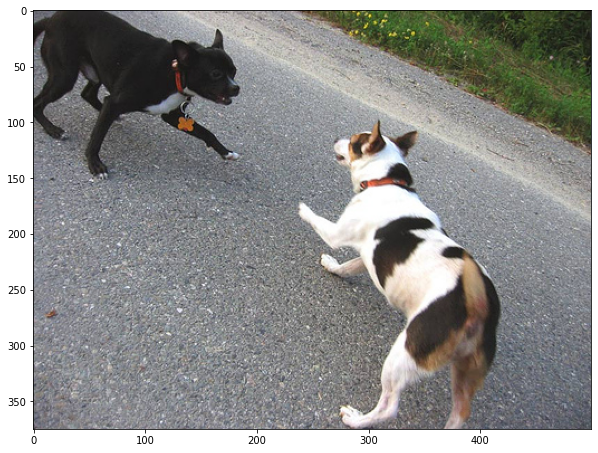

In [8]:
#!g1.1
fig, ax = plt.subplots(figsize=(10,8))
# Для чтения изображений из файлов мы будем использовать библиотеку cv2 --> всё что вам нужно знать
#   функция cv2.imread(path) принимает на вход путь к файлу изображения и возвращает np.array с изображением
#   в порядке HxWxC и значениями от 0 до 255
image = cv2.imread(os.path.join(data_folder, 'train', '0001.png'))
print(type(image))
print(image.shape)
plt.imshow(image)
plt.show()

**Посмотрим на несколько изображений с заголовками**

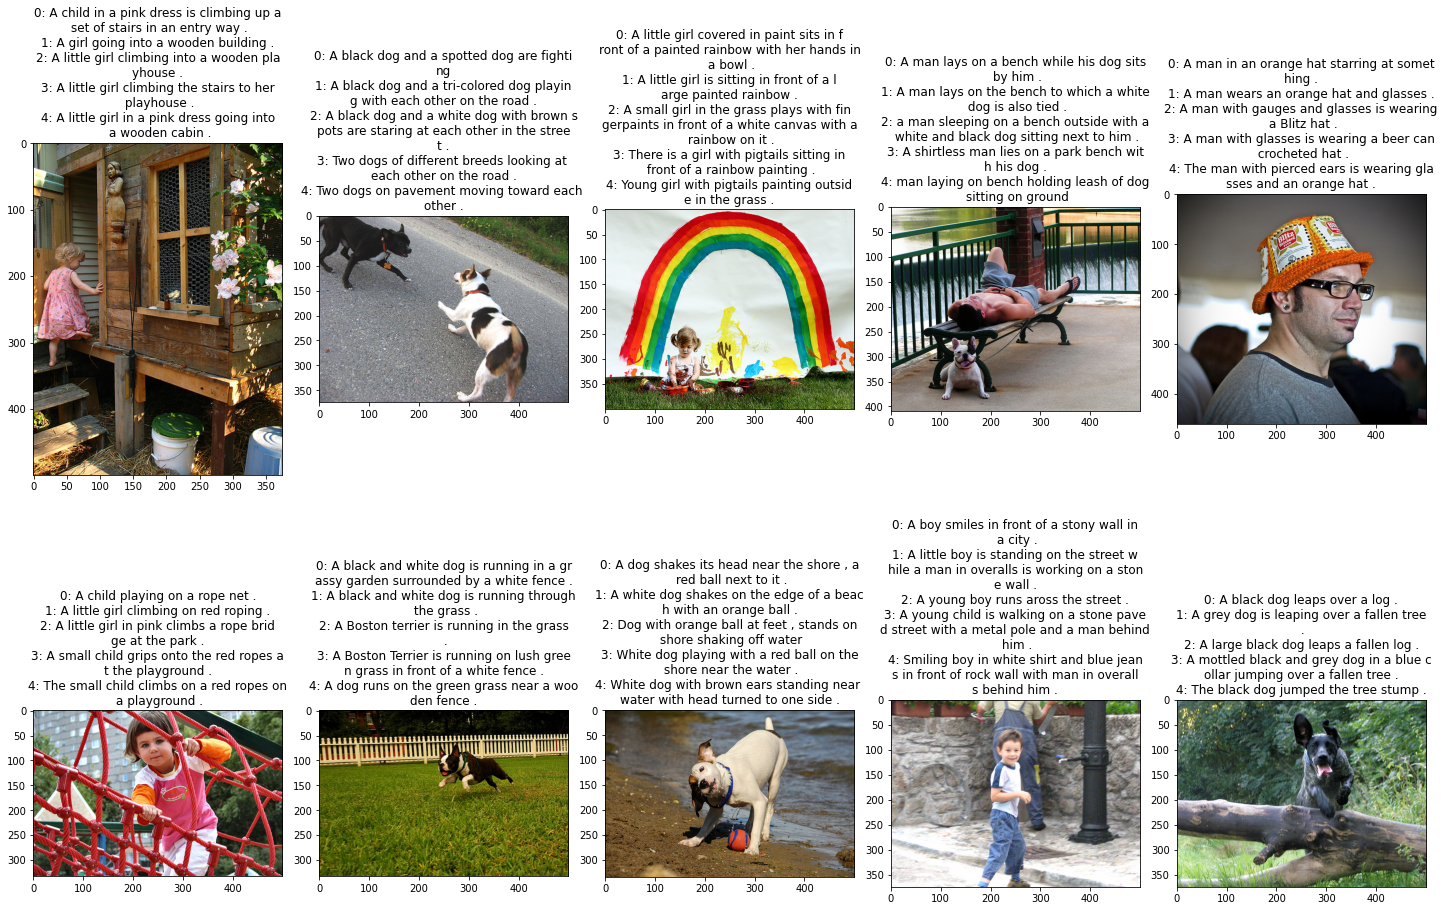

In [9]:
#!g1.1
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    captions = [row[f'caption #{i}'] for i in range(5)]
    
    caption_adjasted = list(map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions)))
    caption = '\n'.join(caption_adjasted)
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(cv2.imread(os.path.join(data_folder, split, img_id)))

fig.tight_layout()
plt.show()

### 1.2 Предобработка изображений

**Сперва напишем предобработку для изображений**

In [10]:
#!g1.1
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr

In [11]:
#!g1.1
# Посчитайте поканальные mean и std для всех изображений из train
train_imgs = [cv2.imread(os.path.join(data_folder, split, img_id)) for img_id in dfs[split]['img_id']]

In [12]:
channels_values = np.hstack([np.array([img[:, :, i].reshape(-1) for i in range(train_imgs[0].shape[2])]) for img in train_imgs])
channels_values.shape

(3, 1066686785)

In [13]:
channel_mean = np.mean(channels_values, axis=1)
channel_mean

array([116.85565898, 113.83522744, 102.86430159])

In [14]:
batch_size = 10000000
channel_stds = np.array([np.std(values_batch, axis=1) for values_batch in np.split(channels_values, np.arange(batch_size, channels_values.shape[1], batch_size), axis=1)])
channel_stds.shape

(107, 3)

In [15]:
channel_stds[:10], channel_stds.mean(axis=0), channel_stds.std(axis=0)

(array([[67.2109933 , 66.69127711, 70.731242  ],
        [69.50039852, 66.53381851, 73.16727132],
        [68.78774363, 66.85166389, 70.0225287 ],
        [71.73690405, 69.51470836, 71.24746764],
        [65.24246617, 66.21827862, 70.77516602],
        [71.26123198, 67.96861971, 72.63778593],
        [70.44886732, 70.25444693, 74.02746878],
        [68.66991553, 65.82881454, 70.81655553],
        [71.83527508, 72.37156337, 77.05139788],
        [64.82164432, 63.78130328, 67.64518498]]),
 array([70.8644614 , 68.95930363, 72.45421896]),
 array([2.9250031 , 3.05444178, 2.97656551]))

In [16]:
channel_std = channel_stds.mean(axis=0)
channel_std

array([70.8644614 , 68.95930363, 72.45421896])

In [17]:
channel_mean /= 255
channel_std /= 255

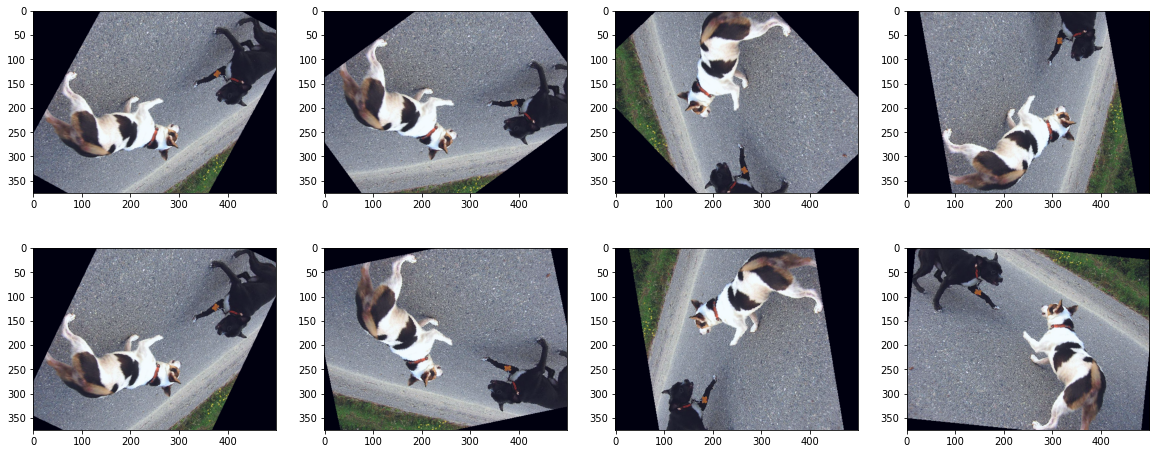

In [18]:
#!g1.1
# Напишите функцию для предобработки одного изображения

image_prepare_vanilla = tr.Compose([
    tr.ToPILImage(),
    # Добавьте любые трансформы, которые считаете нужными из 
    #   https://pytorch.org/vision/stable/transforms.html
    tr.ToTensor(),
    tr.RandomRotation(180),
    tr.Normalize(channel_mean, channel_std)
])

image_prepare = tr.Compose([
    tr.ToPILImage(),
    # Добавьте любые трансформы, которые считаете нужными из 
    #   https://pytorch.org/vision/stable/transforms.html
    tr.ToTensor(),
    tr.RandomRotation(180),
    tr.Resize((255, 255)),
    tr.Normalize(channel_mean, channel_std)
])

image = cv2.imread(os.path.join(data_folder, 'train', '0001.png'))

# Sanity check
from sklearn.preprocessing import minmax_scale

fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    transformed_image = image_prepare_vanilla(image).numpy().transpose(1, 2, 0)
    plt.imshow(minmax_scale(transformed_image.reshape(3, -1), axis=1).reshape(*image.shape))
plt.show()

### 1.3 Предобработка заголовков

**Затем напишем предобработку для заголовков**

Для простоты вычислений предлагаю сделать крайне простую токенизацию, пользуясь регулярными выражениями и библиотекой **re**

1. Приводим текст к нижнему регистру
2. Заменяем всю пунктуацию на пробелы
3. Убираем пробельные символы с концов строки
4. Разбиваем по ненулевой последовательности пробельных символов
5. Добавляем специальные токены \<BOS> (begin of sentence) и \<EOS> (end of sentence), чтобы обозначить границы заголовка для модели

In [19]:
#!g1.1
import re

_BOS_ = '<BOS>'
_EOS_ = '<EOS>'
_UNK_ = '<UNK>'

def tokenize(text):
    clean_text = re.sub(r"""
               [!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               text.lower().strip(), flags=re.VERBOSE)
    return [_BOS_] + clean_text.split() + [_EOS_]
    

In [20]:
tokenize('  Woer ds, dqde!!! deww?.. ..    edew ssss ')

['<BOS>', 'woer', 'ds', 'dqde', 'deww', 'edew', 'ssss', '<EOS>']

Соберём словарь из всех слов, что встречаются в заголовках в train
1. Токенизируем заголовки
2. Обновляем частоту всех отдельных токенов
3. Выкидываем все слова с частотой не больше минимума (допустим 5) -> заменяем на специальный \<UNK> токен
4. Записываем быстрое преобразование из токенов в индексы и наоборот

  0%|          | 0/6000 [00:00<?, ?it/s]

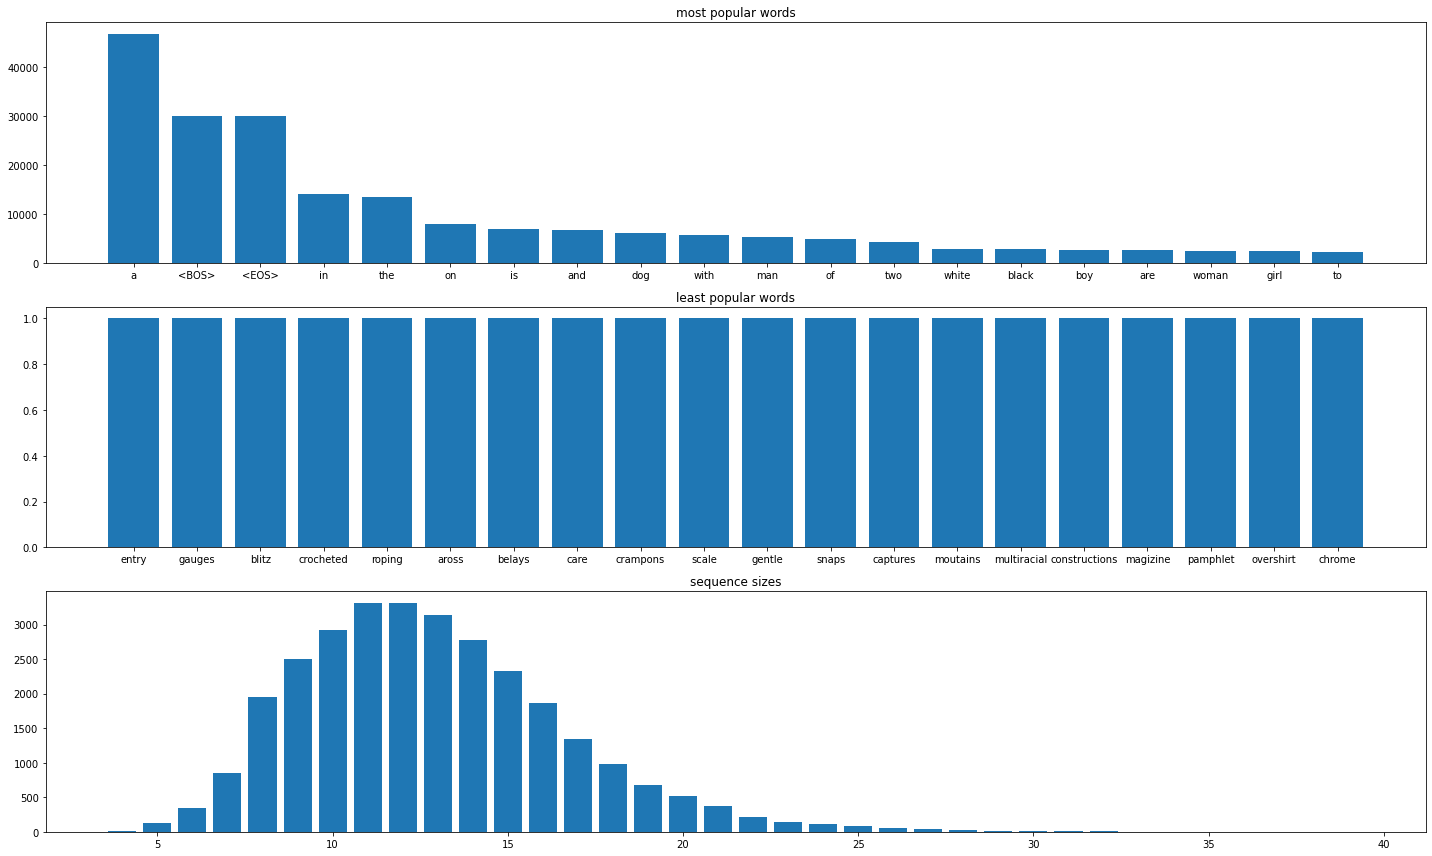

In [21]:
#!g1.1
from tqdm.notebook import trange
from collections import Counter

vocab_freq = Counter()

# Параллельно заодно посчитаем длины заголовках в токенах
sizes = Counter()

for i in trange(len(dfs['train'])):
    for j in range(5):
        caption = dfs['train'].iloc[i][f'caption #{j}']
        tokenized = tokenize(caption)
        sizes.update([len(tokenized)])
        vocab_freq.update(tokenized)
        

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!ОБРАТИ ВНИМАНИЕ!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
max_seq_len = np.max(list(sizes.keys()))
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


show_ = 20
fig, ax = plt.subplots(3, 1, figsize=(20, 12))

plt.subplot(312)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1])}
plt.title('least popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(311)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True)}
plt.title('most popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(313)
plt.title('sequence sizes')
plt.bar(list(sizes.keys()), list(sizes.values()))

fig.tight_layout()
plt.show()

In [22]:
#!g1.1
# Так же добавляем <PAD> токен для паддингов
tok_to_ind = {
    '<UNK>': 0,
    '<BOS>': 1,
    '<EOS>': 2,
    '<PAD>': 3,
}

ind_to_tok = {
    0: '<UNK>',
    1: '<BOS>',
    2: '<EOS>',
    3: '<PAD>',
}

freq_threshold = 5
# Заполнить оставшееся
vocab = [k for k, v in sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True) if v >= freq_threshold and k != _BOS_ and k != _EOS_]
for i, token in enumerate(vocab):
    tok_to_ind[token] = i + 4
    ind_to_tok[i + 4] = token

assert len(tok_to_ind) == len(ind_to_tok)
vocab_size = len(tok_to_ind)
print(vocab_size)

2539


In [23]:
#!g1.1
# Функция возвращает по тексту индексы токенов в тексте
def to_ids(text, padding=None):
    tokens = tokenize(text)
    res = [tok_to_ind[token] if token in tok_to_ind else tok_to_ind['<UNK>'] for token in tokens]
    if padding:
        res += [tok_to_ind['<PAD>'] for _ in range(len(res), padding)]
    return res

In [24]:
#!g1.1
# Проверьте как работают обе функции
text = 'Some random text I wrote. And the one, that can\'t be forgotten unless I\'ll decide that... Tho it\'s still great'
print(tokenize(text))
print(to_ids(text))

['<BOS>', 'some', 'random', 'text', 'i', 'wrote', 'and', 'the', 'one', 'that', 'can', 't', 'be', 'forgotten', 'unless', 'i', 'll', 'decide', 'that', 'tho', 'it', 's', 'still', 'great', '<EOS>']
[1, 104, 0, 0, 1372, 0, 9, 6, 60, 153, 760, 266, 498, 0, 0, 1372, 0, 0, 153, 0, 157, 158, 1540, 2469, 2]


In [25]:
del dfs
del train_imgs
del channels_values
del channel_stds

### 1.4 Датасет

**Сделаем класс датасета в стиле torch.utils.data.Dataset**

In [26]:
#!g1.1
import torch

class ImageCaptioningDataset(Dataset):
    """
        imgs_path ~ путь к папке с изображениями
        captions_path ~ путь к .tsv файлу с заголовками изображений
    """
    def __init__(self, imgs_path, captions_path):
        super(ImageCaptioningDataset).__init__()
        # Читаем и записываем из файлов в память класса, чтобы быстро обращаться внутри датасета
        # Если не хватает памяти на хранение всех изображений, то подгружайте прямо во время __getitem__, но это замедлит обучение
        # Проведите всю предобработку, которую можно провести здесь без потери вариативности датасета
        df = pd.read_csv(captions_path, sep='\t')
        self.imgs = [cv2.imread(os.path.join(imgs_path, img_id)) for img_id in df['img_id']]
        self.captions = [[to_ids(df.iloc[j][f'caption #{i}']) for i in range(df.shape[1] - 1)] for j in trange(df.shape[0])]
        self.image_preprocess = image_prepare

    def __getitem__(self, index):
        ...
        
        # Получаем предобработанное изображение
        ...
        
        # Получаем по каждому заголовку набор in текстов - out слов
        #   в каждом заголовке берём всевозможные не пустые префиксы как in и следующее за префиксом слово как out
        #   применяем padding ко всем текстам в in
        #   in_seqs: torch.tensor \in [\sum{len(caption_i) - 1}; max_seq_len]
        #   out_words: torch.tensor \in [\sum{len(caption_i) - 1}]
        #
        # Можете возвращать вместо набора таких обработанных заголовков только один, чтобы даталоадер позже мог честно перемешать данные,
        #   но тогда подумайте как обработать данные и что будет являться индексом внутри датасета
        caption = self.captions[index][np.random.randint(0, 5)]
        in_seqs = torch.vstack([
            torch.tensor(caption[:i] + [tok_to_ind['<PAD>']] * (max_seq_len - i)) for i in range(1, len(caption))
        ])

        out_words = torch.tensor([
           caption[i] for i in range(1, len(caption))
        ])

        return self.image_preprocess(self.imgs[index]), in_seqs, out_words

#         imgs = []
#         in_seqs = []
#         out_words = []
#         for i in index:
#             img, in_seq, out_word = self.__getitem__(i)
#             imgs.append(img)
#             in_seqs.append(in_seq)
#             out_words.append(out_word)
#         return imgs, in_seqs, out_words
    
    def set_image_preprocessing_function(self, f):
        self.image_preprocess = f
    
    def __len__(self):
        return len(self.imgs)

In [27]:
#!g1.1
ds_train = ImageCaptioningDataset(os.path.join(data_folder, 'train'), os.path.join(data_folder, f'captions_train.tsv'))
ds_val = ImageCaptioningDataset(os.path.join(data_folder, 'val'), os.path.join(data_folder, f'captions_val.tsv'))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
#!g1.1
img_, in_seqs_, out_words_ = ds_train[0]

assert isinstance(img_, torch.Tensor)
assert isinstance(in_seqs_, torch.Tensor)
assert in_seqs_.dtype in {torch.int64, torch.LongTensor}
assert isinstance(out_words_, torch.Tensor)
assert out_words_.dtype in {torch.int64, torch.LongTensor}

assert img_.shape[0] == 3
if len(in_seqs_.shape) == 2:
    assert in_seqs_.shape == (out_words_.shape[0], max_seq_len)
else:
    assert in_seqs_.shape[0] == max_seq_len
    assert out_words_.shape[0] == 1

assert ds_train.__len__() == len(os.listdir(os.path.join(data_folder, 'train')))

print(img_.shape)
print(in_seqs_.shape)
print(out_words_.shape)

torch.Size([3, 255, 255])
torch.Size([13, 39])
torch.Size([13])


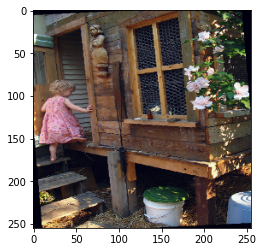

In [29]:
#!g1.1
# Sanity check - изображение всё ещё изображение
shape = img_.shape[1:]
plt.imshow(minmax_scale(img_.numpy().transpose(1, 2, 0).reshape(3, -1), axis=1).reshape(*shape, 3))
plt.show()

In [30]:
#!g1.1
# Только если вы возвращаете сразу группу, если вы возвращаете в __getitem__ один элемент, то просто игнорируйте этот блок
k = 9
# Здесь должна быть лесенка, если вы не перемешиваете дополнительно зачем-то in_seqs в __getitem__
print(in_seqs_[:k+1,:k+1].numpy())
print('\n')
# А тут вы должны узнать эти числа из матрицы выше
print('    ', out_words_[:k].numpy())

[[  1   3   3   3   3   3   3   3   3   3]
 [  1   4   3   3   3   3   3   3   3   3]
 [  1   4  41   3   3   3   3   3   3   3]
 [  1   4  41  20   3   3   3   3   3   3]
 [  1   4  41  20   5   3   3   3   3   3]
 [  1   4  41  20   5   4   3   3   3   3]
 [  1   4  41  20   5   4  89   3   3   3]
 [  1   4  41  20   5   4  89 173   3   3]
 [  1   4  41  20   5   4  89 173 317   3]
 [  1   4  41  20   5   4  89 173 317  66]]


     [  4  41  20   5   4  89 173 317  66]


### 1.5 Даталоадер

In [31]:
#!g1.1
# Сложем батч в list<tensor> для всех данных из батча

def collate_fn(batch):
    return torch.stack([sample[0] for sample in batch]), \
           [sample[1] for sample in batch], \
           [sample[2] for sample in batch]

In [32]:
#!g1.1
batch_size = 64

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

In [33]:
#!g1.1
img_batch, in_seqs_batch, out_words_batch = next(iter(dataloader_train))

assert isinstance(img_batch, (list, torch.Tensor))
assert isinstance(in_seqs_batch, (list, torch.Tensor))
assert isinstance(out_words_batch, (list, torch.Tensor))

assert len(img_batch) == batch_size
assert len(in_seqs_batch) == batch_size
assert len(out_words_batch) == batch_size

assert isinstance(img_batch[0], torch.Tensor)
assert isinstance(in_seqs_batch[0], torch.Tensor)
assert in_seqs_batch[0].dtype in {torch.int64, torch.LongTensor}
assert isinstance(out_words_batch[0], torch.Tensor)
assert out_words_batch[0].dtype in {torch.int64, torch.LongTensor}

assert all([img_batch[i].shape[0] == 3 for i in range(batch_size)])

# Если возвращаете list<torch.Tensor>, иначе игнорируйте
assert all([in_seqs_batch[i].shape == (out_words_batch[i].shape[0], max_seq_len) for i in range(batch_size)])

In [34]:
# смотрим на скорость итерирования по датасету
for i in trange(ds_train.__len__()):
    ds_train[i]

  0%|          | 0/6000 [00:00<?, ?it/s]

## 2. Составляем модель (***2 балла***)

![модель](лаба1_модель.png "Модель")

### 2.1 Фича-экстрактор для изображений

Возьмите какую-нибудь предобученную модель (к примеру resnet), по желанию заморозьте все или часть слоёв, наиболее вероятно уберите последний слой

In [35]:
#!g1.1
from torchvision import models
from torch import nn

In [36]:
#!g1.1
class img_fe_class(nn.Module):
    def __init__(self):
        super(img_fe_class, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.img_fe = torch.nn.Sequential(*(list(resnet.children())[:-1]))
        for param in self.img_fe.parameters():
            param.requires_grad = False
        
    def forward(self, imgs):
        return self.img_fe(imgs).reshape((len(imgs), -1))

In [37]:
#!g1.1
img_fe = img_fe_class()
    
feat_img = img_fe(img_[None,:,:,:])

print(feat_img.shape)
assert len(feat_img.shape) == 2
assert feat_img.shape[0] == 1

print(f'outputs {feat_img.shape[1]} features from feature extractor')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([1, 2048])
outputs 2048 features from feature extractor


In [38]:
img_features_size = feat_img.shape[1]

### 2.2 Фича-экстрактор для текста

Давайте скачаем предобученные glove вектора и инициализируем nn.Embedding ими, там где мы их знаем

In [39]:
#!g1.1:bash
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip -O glove.zip
# mirror https://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip
!unzip -q glove.zip

--2021-10-22 15:05:19--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
Resolving huggingface.co (huggingface.co)... 34.195.144.223, 107.23.77.87, 34.200.164.230, ...
Connecting to huggingface.co (huggingface.co)|34.195.144.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/f47355dd5b267bd10f08671e513790690233c76a9ffd73aa915d78f894a8912e [following]
--2021-10-22 15:05:19--  https://cdn-lfs.huggingface.co/stanfordnlp/glove/f47355dd5b267bd10f08671e513790690233c76a9ffd73aa915d78f894a8912e
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 13.224.96.92, 13.224.96.34, 13.224.96.112, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|13.224.96.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768976 (2.0G) [application/zip]
Saving to: ‘glove.zip’

glove.zip           100%[===================>]   2.03G  18.1MB/s    in 1m 43s  

202

In [40]:
#!g1.1
# Открываем glove
np.random.seed(19)
emb_size = 300

def load_glove_weights(File):
    print("Loading Glove Weights")
    # Инициализируем веса для всех слов стандартным нормальным распределением
    glove_weights = np.random.uniform(0, 1, (vocab_size, emb_size))
    mask_found = [False] * vocab_size
    k = 0
    with open(File,'r') as f:
        for line in tqdm(f, total=2196018):
            split_line = line.split()
            try:
                key = ' '.join(split_line[:-emb_size])
                # берём все слова из key в формате наших токенов (кроме <BOS>, <EOS>)
                words = tokenize(key)[1:-1]
                # Добавляем эмбеддинг из glove, если знаем слово
                for word in words:
                    if word in tok_to_ind and not mask_found[tok_to_ind[word]]:
                        embedding = np.array(list(map(lambda s: 0. if s == '.' else float(s), split_line[-emb_size:])), dtype=np.double)
                        glove_weights[tok_to_ind[word],:] = embedding
                        mask_found[tok_to_ind[word]] = True
                        k += 1
            except:
                continue
    print(f"{k} words from vocab of size {vocab_size} loaded!")
    glove_weights[tok_to_ind['<PAD>']] = np.zeros(emb_size)
    return glove_weights

glove_weights = load_glove_weights('glove.840B.300d.txt')

Loading Glove Weights


  0%|          | 0/2196018 [00:00<?, ?it/s]

2534 words from vocab of size 2539 loaded!


In [41]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [42]:
#!g1.1

class text_fe_class(nn.Module):
    def __init__(self, hid_size=256):
        super(text_fe_class, self).__init__()
        self.hid_size = hid_size
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.embed.weight = nn.Parameter(torch.tensor(glove_weights, dtype=torch.double, device=device))
        self.rnn = nn.GRU(input_size=emb_size, hidden_size=hid_size, num_layers=2, batch_first=True)
        
    def forward(self, in_seqs):
        embeddings = self.embed(in_seqs)  # [n_tokens, max_seq_len, emb_size]
        hidden_states = self.rnn(embeddings.float())[0]  # [n_tokens, max_seq_len, n_tokens]
        last_hidden_states = torch.tensor([list(hidden_state[i]) for i, hidden_state in enumerate(hidden_states)])
        return last_hidden_states

In [43]:
#!g1.1
# Если in_seqs_ - один вектор, то в этом блоке нужно заполнить код чуть иначе
text_fe = text_fe_class().to(device)
feat_text = text_fe(in_seqs_.to(device))

assert in_seqs_.shape[0] == feat_text.shape[0]
assert len(feat_text.shape) == 2, 'По каждому тексту вам нужен один вектор, а RNN блок возвращает output для каждого шага seq_len, не забудьте как-то это исправить'
    
print(in_seqs_.shape)
print(feat_text.shape)

torch.Size([13, 39])
torch.Size([13, 256])


### 2.3 Финальная модель

Сконкатенируйте полученные фичи и подайте в линейный слой (лучше сделать хотя 2 линейных слоя для большей гибкости)

In [44]:
#!g1.1
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# for precise prediction of pad (so the gradient from pad predictions would not effect model parameters)
pad_logits = torch.full(size=(vocab_size, ), fill_value=1e-9)
pad_logits[3] = 1

class image_captioning_model(nn.Module):
    def __init__(self, img_fe, text_fe, device=device, hid_size=256):
        super(image_captioning_model, self).__init__()
        self.img_fe = img_fe.to(device)
        self.text_fe = text_fe.to(device)
        self.device = device
        self.logits = nn.Sequential(
            nn.Linear(img_features_size + text_fe.hid_size, hid_size),
            nn.Tanh(),
            nn.Linear(hid_size, vocab_size)
        )

    def forward(self, img_batch, in_seqs_batch):
        print(img_batch.shape, in_seqs_batch[0].shape)
        img_features = self.img_fe(img_batch.to(self.device))  # [batch_size, img_features_size]
        print('Image features', img_features.shape)
        text_features = [self.text_fe(in_seqs.to(device)) for in_seqs in in_seqs_batch]  # list([n_tokens, text_fe.hid_size]) x batch_size
        print('Text features', len(text_features), text_features[0].shape)
        features = []
        for i in range(len(text_features)):
            for subtext_features in text_features[i]:
                features.append(torch.cat([img_features[i], subtext_features.to(device)]))
        features = torch.stack(features)  # [sum(n_tokens_i), vocab_size]
        print(features.shape)
        return self.logits(features)

In [45]:
#!g1.1
model = image_captioning_model(img_fe, text_fe).float().to(device)

res = model(img_batch, in_seqs_batch)

if isinstance(out_words_batch, list):
    assert res.shape[0] == np.sum([el.shape[0] for el in out_words_batch])
else:
    assert res.shape[0] == out_words_batch.shape[0]
assert res.shape[1] == vocab_size

torch.Size([64, 3, 255, 255]) torch.Size([13, 39])
Image features torch.Size([64, 2048])
Text features 64 torch.Size([13, 256])
torch.Size([769, 2304])


## 3. Пайплайн обучения (***2 балла***)

### 3.1 Оптимайзер

In [46]:
#!g1.1
def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params).float()
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=[beta1, beta2])
    return model, optimizer

model, optimizer = create_model_and_optimizer(
    image_captioning_model, {'img_fe': img_fe_class(), 'text_fe': text_fe_class()}
)

### 3.2 Один шаг обучения/валидации

In [47]:
#!g1.1
def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for img_batch, in_seqs_batch, out_words_batch in tqdm(loader):
        optimizer.zero_grad()
        pred = ...
        loss = ...
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for img_batch, in_seqs_batch, out_words_batch in tqdm(loader):
            pred = ...
            loss = ...

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

### 3.3 Цикл обучения

In [48]:
#!g1.1
from IPython.display import clear_output

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


num_starts = 0

def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=f'model{num_starts}',
    save_only_best=True,
):
    global num_starts
    num_starts += 1
    
    losses = {'train': [], 'val': []}
    best_val_loss = np.Inf
    os.makedirs('./checkpoints', exist_ok=True)
    os.makedirs(os.path.join('./checkpoints', model_name))

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            
            # Сохраняем лучшую по валидации модель
            if ((not save_only_best) or (loss < best_val_loss)):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'losses': losses
                }, os.path.join('./checkpoints', model_name, f'{model_name}#{epoch}.pt'))
                best_val_loss = loss
            
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

### 3.4 Обучаем модель

In [49]:
#!g1.1
%%time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

img_fe = ...
text_fe = ...

model, optimizer = create_model_and_optimizer(
    ...
)

scheduler = ...

criterion = ...

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 10,
    min_lr = None,
    save_only_best = False
)

UsageError: Line magic function `%%time` not found.


### 3.5 Загрузка чекпоинта

#### **Не запускайте этот блок, если не понимаете для чего это в данную секунду!**

#### **Так можно случайно перезатереть несколько часов вычислений, если не скопировать их в отдельную переменную/чекпоинт**

In [ ]:
#!g1.1
model_name = f'model{0}'
epoch = 10
# checkpoint = torch.load(os.path.join('./checkpoints', model_name, f'{model_name}#{epoch}.pt'))
checkpoint = torch.load(os.path.join(f'{model_name}.pt'))

# Создаём те же классы, что и внутри чекпоинта
model, optimizer = create_model_and_optimizer(
    ...
)

scheduler = ...

# Загружаем состояния из чекпоинта
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']

## 4. Оценка результатов (***1 балл***)

### 4.1 Генерация

Подаём модели на вход изображение и \<BOS> токен, получаем лог-вероятности, выбираем большую

Дальше повторяем, но в качестве текста \<BOS> и первый сгенерированный токен

...

генерим по одному токену, пока не сгенерируем \<EOS> или max_seq_len токенов

Возвращаем текст, соединённый через пробелы и без токенов \<BOS>, \<EOS>

In [ ]:
#!g1.1
def generate(model, image):
    model.eval()
    
    with torch.no_grad():
        ...

### 4.2 Посмотрим на предсказания модели

In [ ]:
#!g1.1
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, split, img_id))
    
    pred_caption = generate(model, img)
    pred_caption = '\n'.join([pred_caption[k:k+title_width] for k in range(0, len(pred_caption), title_width)])
    
    captions = [row[f'caption #{i}'] for i in range(5)]
    caption_adjasted = list(map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions)))
    
    caption = '\n'.join(['pred:\n' + pred_caption + '\n\n'] + caption_adjasted)
    
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(img)

fig.tight_layout()
plt.show()

### 4.3 BLEU на всём val датасете

В bleu_score подаются списки кандидатов (токенизированных предсказаний модели) и референсов (токенизированных оригинальных текстов)

Данная метрика активно используется в задачах вроде автоматического перевода и удобна тем, что смотрит сразу на несколько референсов

In [ ]:
#!g1.1
from torchtext.data.metrics import bleu_score

def get_bleu(model):
    candidates = []
    references = []
    ...

    # Здесь считается взвешенный BLEU score по 1-4-граммам, оставьте именно так
    return bleu_score(candidates, references)

bleu_res = get_bleu(model)
print(bleu_res)

## 5. Эксперименты (***2 балла + 10 баллов***)

В этой части у вас не будет никакого написанного мною кода, а всё что вы здесь будете делать - на ваше усмотрение и по вашей задумке

У экспериментов есть две части:
1. Пройти порог BLEU score на валидации (только делайте это честно, если где-то валидация будет протекать в обучение - 0 баллов не думая)

Чтобы получить балл за данную часть - нужно написать такую модель, чтобы в блоке 4.3 получился скор не меньше 
- **0.15 --> 1 балл**
- **0.20 --> 2 балла**

2. Получить высокий BLEU score на отложенном тесте

У меня есть ещё один отложенный тестовый датасет. Последние баллы за лабораторную будут получены в зависимости от результатов именно на нём. Вы должны будете сделать обработчик данных, датасет, модель, ... такие, чтобы они получили как можно больший скор в обобщённом сценарии.

Чтобы получить возможность получить до 10 бонусных баллов - в сданном ноутбуке сделайте отдельный раздел 6, внутри которого должно находится **ВСЁ** необходимое для запуска вашей модели (все классы, загрузчик чекпоинта, ...), вместе с заданием передайте чекпоинт модели, а так же напишите функцию (переиспользуйте уже ранее написанные и объедините вместе), которая на вход будет принимать путь к изображениям, путь к .tsv файлу и путь к чекпоинту модели, а на выход выдавать BLEU score.

Пороги и баллы:
- **0.25 --> 5 баллов**
- **0.30 --> 7.5 баллов**
- **0.35 --> 10 баллов**

**Так же важно:**
1. Процесс обучения данной модели должен находиться в данном ноутбуке в разделах 1-5, чтобы мы видели что чекпоинт правда ваш и написан/обучен вами.
2. Все эксперименты должны быть задокументированы: что вы пробовали, почему, какие результаты получили. Старайтесь максимально качественно описывать все свои эксперименты, потому что за отсутствие или за низкого качества описания экспериментов могут сниматься баллы. 

___Рисуйте графики, таблицы, не забывайте про то, что несколько графиков можно уместить в одном поле вывода, подписывайте оси, пишите заголовки.___

___Простой тест для самих себя - откройте свой ноутбук и дальше читайте только markdown-поля и выводы ячеек, но не сами ячейки с кодом.___

___Если, сделав это, вы не смогли понять что делалось в ноутбуке и какие результаты были получены - что-то явно не так и такого рода работа точно является кандидатом под снижение баллов за оформление и документацию экспериментов___

### **Удачи!**

In [ ]:
#!g1.1
